In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import time
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import minimize

differential drive kinematics model equations

In [5]:
#Preliminaries
def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        final_xp=np.append(final_xp,fx(interp_range))
        final_yp=np.append(final_yp,fy(interp_range))

    return np.vstack((final_xp,final_yp))

def get_nn_idx(state,path):

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.sqrt(dx**2 + dy**2)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

    return target_idx

def road_curve(state,track):
    
    #given vehicle pos find lookahead waypoints
    nn_idx=get_nn_idx(state,track)
    LOOKAHED=6
    lk_wp=track[:,nn_idx:nn_idx+LOOKAHED]

    #trasform lookahead waypoints to vehicle ref frame
    dx = lk_wp[0,:] - state[0]
    dy = lk_wp[1,:] - state[1]

    wp_vehicle_frame = np.vstack(( dx * np.cos(-state[2]) - dy * np.sin(-state[2]),
                                   dy * np.cos(-state[2]) + dx * np.sin(-state[2]) ))

    #fit poly
    return np.polyfit(wp_vehicle_frame[0,:], wp_vehicle_frame[1,:], 3, rcond=None, full=False, w=None, cov=False)

def f(x,coeff):
    return round(coeff[0]*x**3 + coeff[1]*x**2 + coeff[2]*x**1 + coeff[3]*x**0,6)

def df(x,coeff):
    return round(3*coeff[0]*x**2 + 2*coeff[1]*x**1 + coeff[2]*x**0,6)

In [58]:
from math import cos
# Define process model
def kinematics_model(xt,ut,K,dt=0.1):

    #current state
    xp = xt[0]
    yp = xt[1]
    theta = xt[2]
    etheta = xt[4]

    vt = ut[0]
    wt = ut[1]

    #next state
    xtp = xp + vt*cos(theta)*dt
    ytp = yp + vt*np.sin(theta)*dt
    thetatp = theta + wt*dt
    ctetp = f(xp,K) - yp + vt*np.sin(etheta)*dt
    ethetatp = theta - np.arctan(df(xp,K)) + wt*dt
    
    dqdt = [xtp,ytp,thetatp,ctetp,ethetatp]
    return dqdt

simulate

In [63]:
# time points
t = np.arange(0, 40, 0.1)

#fake inputs
# u = [v(t),
#      w(t)]
u = np.zeros((2,len(t)))
u[0,100:]=0.4
u[1,200:]=0.1
u[1,300:]=-0.0

In [64]:
track = compute_path_from_wp([0,5,10],[0,0,2])

# initial conditions
q0 = np.array([0,0,0,0,0])
K = road_curve(q0,track)
q0[3] = f(q0[0],K)
q0[4] = - np.arctan(df(q0[0],K))

# store solution
x = np.empty_like(t)
y = np.empty_like(t)
theta = np.empty_like(t)
cte = np.empty_like(t)
psi = np.empty_like(t)

# record initial conditions
x[0] = q0[0]
y[0] = q0[1]
theta[0] = q0[2]
cte[0] = q0[3]
psi[0] = q0[4]

# solve ODE
for i in range(1,len(t)):
    # span for next time step
    q_t = kinematics_model(q0,u[:,i-1],K,dt=0.1)

    # store solution for plotting
    x[i] = q_t[0]
    y[i] = q_t[1]
    theta[i] = q_t[2]
    cte[i] = q_t[3]
    psi[i] = q_t[4]
    # next initial condition
    q0 = q_t

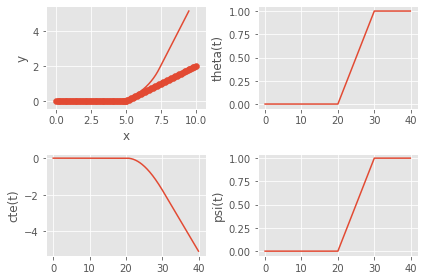

In [65]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x,y)
plt.scatter(track[0,:],track[1,:])
plt.ylabel('y')
plt.xlabel('x')

#plot x(t)
plt.subplot(2, 2, 2)
plt.plot(t,theta)
plt.ylabel('theta(t)')
#plt.xlabel('time')


#plot y(t)
plt.subplot(2, 2, 3)
plt.plot(t,cte)
plt.ylabel('cte(t)')
#plt.xlabel('time')

#plot theta(t)
plt.subplot(2, 2, 4)
plt.plot(t,psi)
plt.ylabel('psi(t)')
#plt.xlabel('time')
#plt.legend(loc='best')

plt.tight_layout()
plt.show()

mpc

In [75]:
# Define Objective function
def objective(u_hat,*args):
    """
    Computes objective function
    
    :param u_hat: array_like, input [v,w
                                     v,w
                                     ...]
    """
    
    #undo input flattening
    u_hat = u_hat.reshape(2, -1).T
    se = np.zeros(PRED_HZN) #squared_errors
    
    # Prediction
    for k in range(PRED_HZN):
        
        # Initialize state for prediction
        if k==0:
            q_hat0 = args[0]
            K=args[1] #road curve
        
        # Clamp control horizon
        elif k>CTRL_HZN:
            u_hat[k,:] = u_hat[CTRL_HZN,:]
       
        #DEBUG
#         print("k : {}".format(k))
#         print("q_hat0 : {}".format(q_hat0))
#         print("ts : {}".format(ts_hat))
#         print("u_hat : {}".format(u_hat[k,:]))
        
        q_hat = kinematics_model(q_hat0,u_hat[k,:],K,dt=0.1)
        cte=q_hat[3]
        psi=q_hat[4]
        
        q_hat0 = q_hat[:]

        if k >0:
            delta_u_hat = np.sum(u_hat[k,:]-u_hat[k-1,:])
        else:
            delta_u_hat = 0

        se[k] = 100 * (cte)**2 + 15 *(psi)**2 + 15 * (delta_u_hat)**2

    # Sum of Squared Error calculation
    obj = np.sum(se[1:])
    return obj

TODO: add heading error

test optimization

In [76]:
#PARAMS
v=1.5
vb=0.5
wb=0.5

# Define horizons
PRED_HZN = 20 # Prediction Horizon
CTRL_HZN = 15  # Control Horizon

delta_t_hat = 0.1 #time step

In [77]:
starting_pos=np.array([0,0.25,0.15])
track = compute_path_from_wp([0,5,10],[0,0,2])
K = road_curve(starting_pos,track)

# initial conditions
q0 = np.array([0,0,0,0,0])
q0[3] = f(q0[0],K)
q0[4] = - np.arctan(df(q0[0],K))

#starting guess
u_hat0 = np.zeros((PRED_HZN,2))
u_hat0[:,0]=v
u_hat0[:,1]=0.1
u_hat0=u_hat0.flatten("F")

bnds=((v-2*vb,v+vb),)
for i in range (PRED_HZN-1):
    bnds=bnds+((v-2*vb,v+vb),)
    
bnds=bnds+((-wb,wb),)
for i in range (PRED_HZN-1):
    bnds=bnds+((-wb,wb),)

# print(u_hat0)
# print(u_hat0.reshape(2, -1).T)

start = time.time()

solution = minimize(objective,u_hat0,args=(q0[:],K,),method='SLSQP',bounds=bnds,options={'maxiter':100})

end = time.time()

print(solution)
print("time elapsed: {}".format(end-start))

     fun: 84.46152413856359
     jac: array([-1.65424156, -5.46248531, -4.66883278, -3.61091423, -7.25656319,
       -9.97307396, -7.68648052, -5.46970558, -3.82968616,  0.67185783,
       -1.15515804, -1.96808815,  1.28362656, -2.83778381, -0.42825508,
       -0.31342316,  0.        ,  0.        ,  0.        ,  0.        ,
       38.85329056, 29.67042637, 24.17370987, 19.24147987, 10.30806732,
        3.07283115,  1.61050224,  0.68769073, -0.09304619,  2.58471298,
       -0.30147457, -1.62229347,  1.39114475, -2.71041679, -0.22286892,
        1.22416592,  0.        ,  0.        ,  0.        ,  0.        ])
 message: 'Iteration limit exceeded'
    nfev: 5103
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([ 1.64242978,  1.69757121,  1.81361202,  1.90182763,  1.90182763,
        1.90182763,  1.90182763,  1.90182763,  1.83511965,  1.84792843,
        1.68088567,  1.43951262,  1.44726228,  1.25067572,  1.25506942,
        1.37310177,  1.37310177,  1.37310177,  1.37

check what the optimizer returns

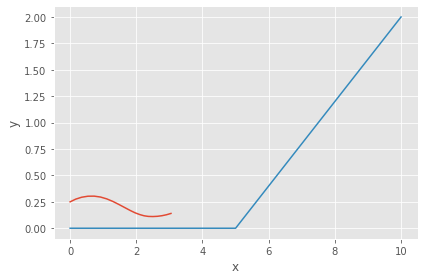

In [78]:
u=solution.x.reshape(2,-1).T
x=[]
y=[]
theta=[]
x.append(starting_pos[0])
y.append(starting_pos[1])
theta.append(starting_pos[2])

for i in range(1,np.shape(u)[0]):
    
    # store solution for plotting
    x.append(x[-1]+u[i,0]*np.cos(theta[-1])*0.1)
    y.append(y[-1]+u[i,0]*np.sin(theta[-1])*0.1)
    theta.append(theta[-1]+u[i,1]*0.1)
    
plt.plot(x,y)
plt.plot(track[0,:],track[1,:])
plt.ylabel('y')
plt.xlabel('x')

plt.tight_layout()
plt.show()

compute MPC on the whole path

In [83]:
curr_pos=np.array([0,0.25,0.15])
start_wpx=[0,5,7.5,8,10,15]
start_wpy=[0,0,5,10,10,12]
track = compute_path_from_wp(start_wpx,start_wpy)
x=[]
y=[]
theta=[]
x.append(curr_pos[0])
y.append(curr_pos[1])
theta.append(curr_pos[2])

opt_time=[]

# Initialize input for prediction horizon
# u=[v1,v2,...,vp
#    w1,w2,...,wp]

# Initial guess 
# u_hat0=[v1,v2,..vp,w1,w2,...,wp]
# uhat0 -> u_hat=optimize(obj,u_hat0)

u_hat0 = np.zeros((PRED_HZN,2))
u_hat0[:,0]=v
u_hat0[:,1]=0.01
u_hat0=u_hat0.flatten("F")

# Optimization Bounds
# bnds=((v1_min,v1_max),...,(vp_min,vp_max),(w1_min,w1_max),...,(wp_min,wp_max))

bnds=((v-2*vb,v+vb),)
for i in range (1,PRED_HZN):
    bnds=bnds+((v-2*vb,v+vb),)
    
bnds=bnds+((-wb,wb),)
for i in range (1,PRED_HZN):
    bnds=bnds+((-wb,wb),)

#while np.sum(np.abs(q[-1,0:2]-path[-1,0:2]))>0.1:
for i in range(50):   
    
    start = time.time()
    K = road_curve(curr_pos,track)
    
    # initial conditions for opt.
    q0 = np.array([0,0,0,0,0])
    q0[3] = f(q0[0],K)
    q0[4] = - np.arctan(df(q0[0],K))

    #MPC LOOP
    u_hat = minimize(objective,
                     u_hat0,
                     args=(q0,K,),
                     method='SLSQP',
                     bounds=bnds,
                     options={'maxiter':100}
                    ).x
    
    end = time.time()
    opt_time.append(end-start)
    
    # store solution for plotting
    x.append(x[-1]+u[0,0]*np.cos(theta[-1])*0.1)
    y.append(y[-1]+u[0,0]*np.sin(theta[-1])*0.1)
    theta.append(theta[-1]+u[0,1]*0.1)
    
    next_pos = [x[-1],y[-1],theta[-1]]
    
    # next initial condition
    curr_pos=next_pos
    u_hat0=u_hat

print("SCIPY Optimization Time: Avrg: {:.4f}s Max: {:.4f}s Min: {:.4f}s".format(np.mean(opt_time),
                                                                            np.max(opt_time),
                                                                            np.min(opt_time))) 

SCIPY Optimization Time: Avrg: 0.2300s Max: 3.1533s Min: 0.0260s


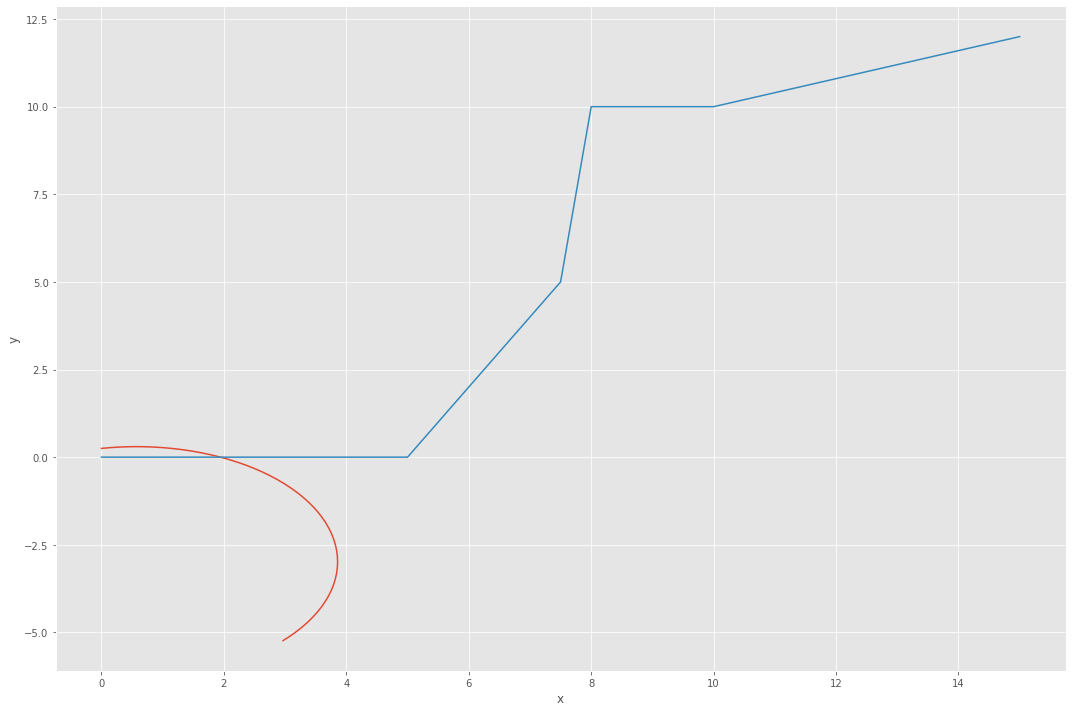

In [84]:
plt.figure(figsize=(15,10))

plt.plot(x[:],y[:])
plt.plot(track[0,:],track[1,:])
plt.ylabel('y')
plt.xlabel('x')

plt.tight_layout()

plt.show()